In [1]:
import numpy as np
import cv2 
import glob
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
#from tracker import tracker

## Camera calibration

In [2]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ... (0,3,0)
objp = np.zeros((6*9, 3), np.float32)
objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

# arrays to store object points and image points from all the images
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane

# make a list of calibration images
images = glob.glob('./camera_cal/calibration*jpg')
print('Number of images: ', len(images))

# Step throught the list and search for chessboard corners
for idx, fname in enumerate(images):
    img = cv2.imread(fname)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # find the chessboard corners
    # ret - boolean - if returned corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    # if found, add object points, image points
    if ret == True:
        print('working on ', fname)
        objpoints.append(objp)
        imgpoints.append(corners)
        
        # draw and display the corners
        cv2.drawChessboardCorners(img, (9,6), corners, ret)
        write_name = './camera_cal/corners_found'+str(idx)+'.jpg'
        cv2.imwrite(write_name, img)

# load image for reference
img = cv2.imread('./camera_cal/calibration1.jpg')
img_size = (img.shape[1], img.shape[0])

# do camera calibtration given object pointsand imate points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size, None, None)

# save the camera calibration result for later use 
dist_pickle = {}
dist_pickle["mtx"] = mtx
dist_pickle["dist"] = dist
pickle.dump(dist_pickle, open("./camera_cal/calibration_pickle.p", "wb"))

Number of images:  20
working on  ./camera_cal/calibration10.jpg
working on  ./camera_cal/calibration6.jpg
working on  ./camera_cal/calibration9.jpg
working on  ./camera_cal/calibration7.jpg
working on  ./camera_cal/calibration19.jpg
working on  ./camera_cal/calibration20.jpg
working on  ./camera_cal/calibration16.jpg
working on  ./camera_cal/calibration17.jpg
working on  ./camera_cal/calibration2.jpg
working on  ./camera_cal/calibration8.jpg
working on  ./camera_cal/calibration15.jpg
working on  ./camera_cal/calibration3.jpg
working on  ./camera_cal/calibration14.jpg
working on  ./camera_cal/calibration11.jpg
working on  ./camera_cal/calibration13.jpg
working on  ./camera_cal/calibration12.jpg
working on  ./camera_cal/calibration18.jpg


In [3]:
# read in the saved objpoints and imgpoints
dist_pickle = pickle.load( open("./camera_cal/calibration_pickle.p", "rb"))
mtx = dist_pickle["mtx"]
dist = dist_pickle["dist"]

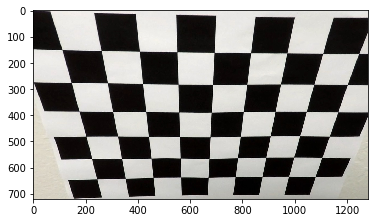

In [30]:
cam_img = mpimg.imread('./camera_cal/calibration2.jpg')
cam_calibrated_img = cv2.undistort(cam_img, mtx, dist, None, mtx)
plt.imshow(cam_calibrated_img)
plt.savefig('cam_calibrated_img.jpg')

In [5]:
# Define a function that takes an image, gradient orientation,
# and threshold min / max values.

def abs_sobel_thresh(img, orient='x', thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

# Define a function to return the magnitude of the gradient
# for a given sobel kernel size and threshold values
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # Return the binary image
    return binary_output

# Define a function to threshold an image for a given range and Sobel kernel
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # Return the binary image
    return binary_output

def color_threshold(image, sthresh=(0,255), vthresh=(0,255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    s_binary =  np.zeros_like(s_channel)
    s_binary[(s_binary >= sthresh[0]) & (s_binary <= sthresh[1])] = 1
    hsv = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
    v_channel = hsv[:,:,2]
    v_binary =  np.zeros_like(v_channel)
    v_binary[(v_binary >= vthresh[0]) & (v_binary <= vthresh[1])] = 1
    output = np.zeros_like(s_channel)
    output[(s_binary == 1) & (v_binary == 1)] = 1
    return output

def color_s_threshold(image, sthresh=(0,255)):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    binary = np.zeros_like(S)
    binary[(S > sthresh[0]) & (S <= sthresh[1])] = 1
    return binary

def color_l_LUV_threshold(img, thresh=(0, 255)):
    l_channel = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)[:,:,0]
    l_thresh_min = thresh[0]
    l_thresh_max = thresh[1]
    l_binary = np.zeros_like(l_channel)
    l_binary[(l_channel >= l_thresh_min) & (l_channel <= l_thresh_max)] = 1
    return l_binary
    
def color_s_HLS_threshold(img, thresh=(0, 255)):
    s_channel = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)[:,:,2]
    s_thresh_min = thresh[0]
    s_thresh_max = thresh[1]
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh_min) & (s_channel <= s_thresh_max)] = 1
    return s_binary

def color_b_Lab_threshold(img, thresh=(0, 255)):
    b_channel = cv2.cvtColor(img, cv2.COLOR_RGB2Lab)[:,:,2]  
    b_thresh_min = thresh[0]
    b_thresh_max = thresh[1]
    if np.max(b_channel) > 175:
        b_channel = b_channel * (255 / np.max(b_channel))
    b_binary = np.zeros_like(b_channel)
    b_binary[((b_channel >= b_thresh_min) & (b_channel <= b_thresh_max))] = 1
    return b_binary 

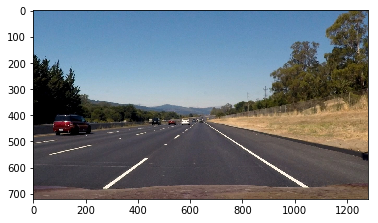

In [6]:
#img = mpimg.imread('./test_images/learn3.jpg')
#img = mpimg.imread('./test_images/test6.jpg')
img = mpimg.imread('./test_images/straight_lines2.jpg')
plt.imshow(img)

In [7]:
def cal_undistort(img):
    result = cv2.undistort(img, mtx, dist, None, mtx)
    return result

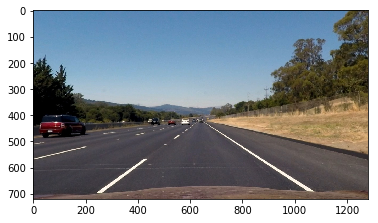

In [8]:
undistort_img = cal_undistort(img)
plt.imshow(undistort_img)

## Perspective transform

In [9]:
def warp_image(img):
    src = np.float32([(560,453), (720,453), 
                  (170,720), (1150,720)])
    dst = np.float32([(80,0), (1200,0),
                  (80,720), (1200,720)])

    h,w = img.shape[:2]
    # Compute the perspective transform, M, given source and destination points:
    M = cv2.getPerspectiveTransform(src, dst)
    # Compute the inverse perspective transform:
    Minv = cv2.getPerspectiveTransform(dst, src)
    # Warp an image using the perspective transform, M:

    warped = cv2.warpPerspective(img, M, (w,h), flags=cv2.INTER_LINEAR)
    return warped, M, Minv

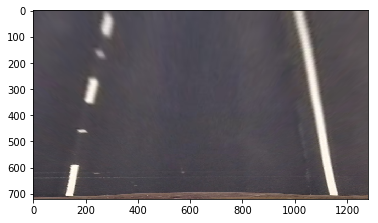

In [10]:
warped, M, Minv = warp_image(undistort_img)
plt.imshow(warped)

## Combined thresholding

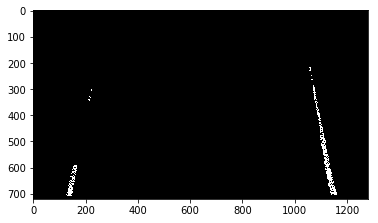

In [11]:
test = abs_sobel_thresh(warped, orient='x', thresh=(35, 255))
test = color_s_HLS_threshold(warped, thresh=(180,240))
#test = color_b_Lab_threshold(warped, thresh=(200,255))
#test = color_l_LUV_threshold(warped, thresh=(200,255))
plt.imshow(test, cmap='gray')

In [12]:
def threshold(image):
    s_binary = color_s_HLS_threshold(image, thresh=(180,240))
    b_binary = color_b_Lab_threshold(image, thresh=(200,255))
    l_binary = color_l_LUV_threshold(image, thresh=(200,255))
    abs_sobel = abs_sobel_thresh(image, orient='x', thresh=(35, 255))

    combined_binary = np.zeros_like(s_binary)
    combined_binary[(l_binary == 1) | (b_binary == 1) | (abs_sobel == 1)] = 1
    return combined_binary

(720, 1280)


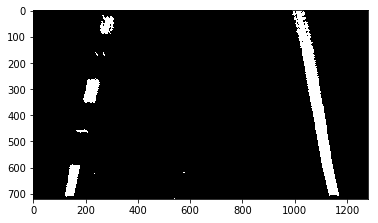

In [13]:
result = threshold(warped)
plt.imshow(result, cmap='gray')
print(result.shape)

/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:1: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  if __name__ == '__main__':


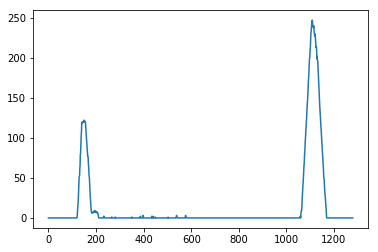

In [14]:
histogram = np.sum(result[result.shape[0]/2:,:], axis=0)
plt.plot(histogram)

(720, 0)

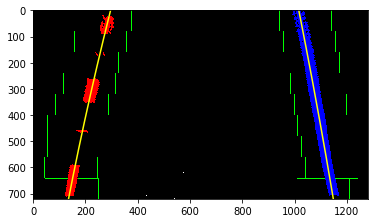

In [15]:
# Create an output image to draw on and  visualize the result
out_img = np.dstack((result, result, result))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(result.shape[0]/nwindows)

nonzero = result.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])

# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one

for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = result.shape[0] - (window+1)*window_height
    win_y_high = result.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

# Generate x and y values for plotting
ploty = np.linspace(0, result.shape[0]-1, result.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
(720, 0)

(720, 0)

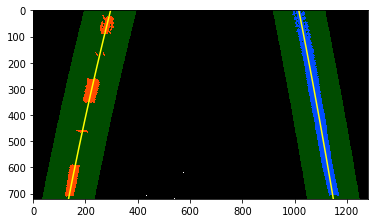

In [16]:
# Assume you now have a new warped binary image 
# from the next frame of video (also called "result")
# It's now much easier to find line pixels!
margin = 100
left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  

# Again, extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds]
# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)
# Generate x and y values for plotting
ploty = np.linspace(0, result.shape[0]-1, result.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

# Create an image to draw on and an image to show the selection window
out_img = np.dstack((result, result, result))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)

In [17]:
def sliding_window_lines_finding(img):
    histogram = np.sum(img[img.shape[0]/2:,:], axis=0)

    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(img.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = img.shape[0] - (window+1)*window_height
        win_y_high = img.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        #cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
        #cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 

        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit, left_lane_inds, right_lane_inds

In [18]:
def highly_targeted_lines_finding(img_bin, prev_left_fit, prev_right_fit):
    nonzero = img_bin.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 100
    left_lane_inds = ((nonzerox > (prev_left_fit[0]*(nonzeroy**2) + prev_left_fit[1]*nonzeroy + prev_left_fit[2] - margin)) & (nonzerox < (prev_left_fit[0]*(nonzeroy**2) + prev_left_fit[1]*nonzeroy + prev_left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (prev_right_fit[0]*(nonzeroy**2) + prev_right_fit[1]*nonzeroy + prev_right_fit[2] - margin)) & (nonzerox < (prev_right_fit[0]*(nonzeroy**2) + prev_right_fit[1]*nonzeroy + prev_right_fit[2] + margin)))  

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    return left_fit, right_fit, left_lane_inds, right_lane_inds

In [19]:
def calculate_radius_and_meters_from_center(img, left_fit, right_fit, left_lane_inds, right_lane_inds):

    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3.048/80 # meters per pixel in y dimension
    xm_per_pix = 3.7/1040 # meters per pixel in x dimension

    # Define y-value where we want radius of curvature
    # I'll choose the maximum y-value, corresponding to the bottom of the image
    ploty = np.linspace(0, img.shape[0]-1, img.shape[0] )
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])

    nonzero = img.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])

    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    # Generate x and y values for plotting
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    # Fit new polynomials to x,y in world space
    left_fit_cr = np.polyfit(ploty*ym_per_pix, left_fitx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(ploty*ym_per_pix, right_fitx*xm_per_pix, 2)

    # Calculate the new radius of curvature
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])

    # Calculate meters from center
    screen_middel_pixel = img.shape[1]/2
    left_lane_pixel = left_fitx[0]    # x position for left lane
    right_lane_pixel = right_fitx[0]   # x position for right lane
    car_middle_pixel = int((right_lane_pixel + left_lane_pixel)/2)
    screen_off_center = screen_middel_pixel - car_middle_pixel
    meters_off_center = xm_per_pix * screen_off_center

    return left_curverad, right_curverad, meters_off_center

In [20]:
left_curverad, right_curverad, meters_off_center = calculate_radius_and_meters_from_center(result, left_fit, right_fit, left_lane_inds, right_lane_inds)
print('Left curverad', left_curverad, 'm', 'right curverad', right_curverad, 'm')
print('Meters of center: ', meters_off_center)

Left curverad 61.4705977298 m right curverad 64.5645913856 m
Meters of center:  -0.20278846153846153


/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:19: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 331603 but corresponding boolean dimension is 42073
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:20: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 331603 but corresponding boolean dimension is 42073
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:21: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 331603 but corresponding boolean dimension is 42073
/home/carnd/anaconda3/envs/carnd-term1/lib/python3.5/site-packages/ipykernel/__main__.py:22: VisibleDeprecationWarning: boolean index did not match indexed array along dimension 0; dimension is 331603 but corresponding boolean dimension is 42073


In [21]:
def warp_back(img, binary_warped, left_fit, right_fit, Minv, left_curverad, right_curverad, meters_off_center):

    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    yvals = np.linspace(0, img.shape[0] - 1, img.shape[0])
    left_fitx = left_fit[0]*yvals**2 + left_fit[1]*yvals + left_fit[2]
    right_fitx = right_fit[0]*yvals**2 + right_fit[1]*yvals + right_fit[2]

    pts_left = np.array([np.transpose(np.vstack([left_fitx, yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, yvals])))])
    pts = np.hstack((pts_left, pts_right))

    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
    avg_curverad = int((left_curverad + right_curverad)/2)

    # add text to image
    font = cv2.FONT_HERSHEY_SIMPLEX
    radius_text = "Radius of Curvature = {} m,".format(avg_curverad)
    center_text = "Vehicle's position to center: {:.2f} m".format(meters_off_center)
    cv2.putText(result,radius_text,(250,100), font, 1,(255,255,255),2,cv2.LINE_AA)
    cv2.putText(result,center_text,(250,140), font, 1,(255,255,255),2,cv2.LINE_AA)
    #plt.text(600, 100, text, horizontalalignment='center', verticalalignment='center', color='white')
    return result

In [22]:
def pipeline(image):
    undistort_img = cal_undistort(image)
    warped_img, M, Minv = warp_image(undistort_img)
    thresh_img = threshold(warped_img)
    img_bin = thresh_img

    return img_bin, M, Minv   

In [23]:
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.current_fit = []  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        
    def update(self, fit, inds):
        if fit is not None:
            if self.best_fit is not None:
                self.diffs = abs(fit-self.best_fit)

            if (self.diffs[0] > 0.001 or self.diffs[1] > 1.0 or self.diffs[2] > 100.) and len(self.current_fit) > 0:
                self.detected = False
                if len(self.current_fit) > 1:
                    self.current_fit = self.current_fit[1:]
                    self.best_fit = np.average(self.current_fit, axis=0)
                elif len(self.current_fit) <= 1:
                    self.current_fit = []
                    self.best_fit = None

            else:
                self.detected = True
                self.current_fit.append(fit)
                if len(self.current_fit) > 5:
                    self.current_fit = self.current_fit[1:]
                self.best_fit = np.average(self.current_fit, axis=0)
        else:
            self.detected = False
            if len(self.current_fit) > 1:
                self.current_fit = self.current_fit[1:]
                self.best_fit = np.average(self.current_fit, axis=0)
            elif len(self.current_fit) <= 1:
                self.current_fit = []
                self.best_fit = None

In [24]:
def process_image(img):
    new_img = np.copy(img)
    img_bin, M, Minv = pipeline(new_img)
   
    if not l_line.detected or not r_line.detected:
        l_fit, r_fit, l_lane_inds, r_lane_inds = sliding_window_lines_finding(img_bin)
    else:
        l_fit, r_fit, l_lane_inds, r_lane_inds = highly_targeted_lines_finding(img_bin, 
                                                                               l_line.best_fit, r_line.best_fit)

    if l_fit is not None and r_fit is not None:
    # calculate x-intercept (bottom of image, x=image_height) for fits
        h = img.shape[0]
        l_fit_x_int = l_fit[0]*h**2 + l_fit[1]*h + l_fit[2]
        r_fit_x_int = r_fit[0]*h**2 + r_fit[1]*h + r_fit[2]
        x_int_diff = abs(r_fit_x_int-l_fit_x_int)
        if abs(350 - x_int_diff) < 600:
            l_fit = None
            r_fit = None

    l_line.update(l_fit, l_lane_inds)
    r_line.update(r_fit, r_lane_inds)

    if l_line.best_fit is not None and r_line.best_fit is not None:
        l_curverad, r_curverad, meters_off_center = calculate_radius_and_meters_from_center(img_bin, 
                                                                                                   l_line.best_fit, 
                                                                                                   r_line.best_fit,
                                                                                                   l_lane_inds, 
                                                                                                   r_lane_inds)

        result_img = warp_back(new_img, img_bin, l_line.best_fit, r_line.best_fit, 
                               Minv, l_curverad, r_curverad, meters_off_center)
    else:
        result_img = new_img

    return result_img

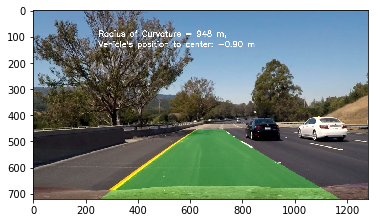

In [29]:
img = mpimg.imread('./test_images/test6.jpg')
l_line = Line()
r_line = Line()

processed_img = process_image(img)
plt.imshow(processed_img, cmap='gray')

In [26]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [27]:
l_line = Line()
r_line = Line()

video_output = 'project_output_video.mp4'
input_clip = VideoFileClip("project_video.mp4")
result_clip = input_clip.fl_image(process_image) #NOTE: this function expects color images!!
%time result_clip.write_videofile(video_output, audio=False)

[MoviePy] >>>> Building video project_output_video.mp4
[MoviePy] Writing video project_output_video.mp4


100%|█████████▉| 1260/1261 [03:15<00:00,  6.47it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_output_video.mp4 

CPU times: user 8min 42s, sys: 14.3 s, total: 8min 56s
Wall time: 3min 16s
